<a href="https://colab.research.google.com/github/anuarsantoyo/master-thesis/blob/master/evaluation_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
import imageio
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

# Import Data

In [5]:
#%cd ..

In [40]:
df, cluster_input_cols, answers_train, answers, labels, _ = get_cluster_data(n_cluster=5, method='gmm', cov_type='full', cluster_input_data='fa_data', start_train='2020-07-31', end_train='2020-12-01')

# Metrics

In [41]:
ch_score = metrics.calinski_harabasz_score(answers, labels)
silhouette_score = metrics.silhouette_score(answers, labels, metric='euclidean')
print('Calinski Harabasz Score: ' + str(ch_score))
print('Silhouette Score: ' + str(silhouette_score))

Calinski Harabasz Score: 3436.211297845022
Silhouette Score: 0.01965825707768225


# Plot Group Size

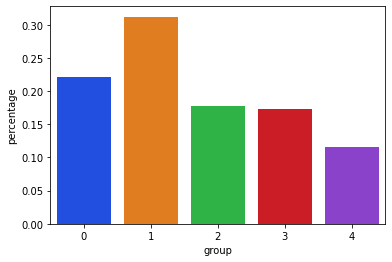

In [42]:
df_group_size = df[['group', 'gender']].groupby('group').count().reset_index()
df_group_size['gender'] = df_group_size['gender'] / df_group_size['gender'].sum()
df_group_size.rename(columns={'gender':'percentage'}, inplace=True)
sns.barplot(data=df_group_size, x='group', y='percentage', palette='bright')

In [43]:
df_group_size

,group,percentage
0,0,0.221507
1,1,0.312141
2,2,0.177365
3,3,0.173053
4,4,0.115934


# Heatmap - Comparison: group dependend average factor values to overall average factor values

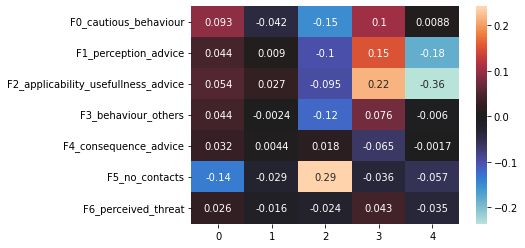

In [44]:
df_heatmap = pd.DataFrame(data=answers, columns=cluster_input_cols)
df_heatmap['group'] = labels
df_heatmap = df_heatmap.groupby('group').mean().reset_index(drop=True).transpose()
for col in df_heatmap.columns:
  df_heatmap[col] = df_heatmap[col] - answers.mean(axis=0)
sns.heatmap(df_heatmap, center=0, robust=True, annot=True)

# Daily Distribution

In [13]:
df_perc = df.groupby(['date','group'],as_index=False)['gender'].count()
def normalize(row):
  sum = df_perc[df_perc['date']==row['date']]['gender'].sum()
  return row['gender']/sum
df_perc['percentage'] = df_perc.apply(lambda x: normalize(x), axis=1)
df_perc_roll_avg = pd.DataFrame()
for group in np.arange(len(df_perc['group'].unique())):
  df_temp = df_perc[df_perc['group']==group].groupby('date').mean().rolling(7).mean().reset_index()
  df_perc_roll_avg = pd.concat([df_perc_roll_avg, df_temp])
df_perc_roll_avg.dropna(inplace=True)
df_perc_roll_avg.reset_index(inplace=True, drop=True)
df_perc_roll_avg.drop(columns='gender',inplace=True)
fig = px.line(df_perc_roll_avg, x="date", y="percentage", color='group', title='7 day average daily distribution of group sizes')
fig.show()

# Pairgrid Factors

In [14]:
start = '2020-09-01'
end = '2020-09-14'
in_range = (df.date > start) & (df.date < end)
df_timewindow = df[in_range]

In [15]:
%matplotlib inline
g = sns.PairGrid(data=df_timewindow, vars=cluster_input_cols, hue='group', palette='bright')
g.map_upper(sns.scatterplot, alpha=0.1)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f0c2b744950> (for post_execute):


KeyboardInterrupt: ignored

# 3D Scatterplot

In [ ]:
df_timewindow.group = df_timewindow.group.astype(str)
fig = px.scatter_3d(df_timewindow, x=cluster_input_cols[0], y=cluster_input_cols[2], z=cluster_input_cols[5], color='group', opacity=1)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=5, range=[0, 7],),
                     yaxis = dict(nticks=5, range=[0, 7],),
                     zaxis = dict(nticks=5, range=[0, 12],),),
        width=1600, height=700, margin=dict(r=20, l=10, b=10, t=10))
fig.show()

# Daily Average Group Answer

In [ ]:
df_roll_daily_avg = pd.DataFrame()
for group in np.arange(len(df_perc['group'].unique())):
  df_temp = df[df['group']==group].groupby('date').mean().rolling(7).mean().reset_index()
  df_roll_daily_avg = pd.concat([df_roll_daily_avg, df_temp])
df_roll_daily_avg.reset_index(inplace=True, drop=True)

In [ ]:
df_daily_average = df.groupby(['date','group']).mean().reset_index()
df_daily_average.date = pd.to_datetime(df_daily_average.date)
for col in cluster_input_cols:
    sns.lineplot(data=df_roll_daily_avg, x='date', y=col, hue='group', palette="bright")
    sns.lineplot(data=df_roll_daily_avg, x='date', y=col)
    plt.title(col)
    plt.show()

# Observations

In [ ]:
observations = pd.read_csv('data/observations_30012022.csv',sep=';', decimal=',', encoding='utf-8', index_col='Unnamed: 0')
observations.Date = pd.to_datetime(observations.Date, format='%Y-%m-%d')
start = '2020-08-01'
end = '2021-02-01'
in_range = (observations.Date > start) & (observations.Date < end)
observations = observations[in_range]
observations.head()

In [ ]:
fig = px.line(observations, x="Date", y=['Confirmed_cases', 'Admissions_hospital'])
fig.show()

# Group distance

In [ ]:
df_dict = []
for i, day in  df[behaviour_cols + ['date', 'group']].groupby(['date']):
     groups_dist = np.abs(day[day['group']== 0].mean() - day[day['group']== 1].mean())
     dist = np.linalg.norm(groups_dist.values, ord=1)
     df_dict.append({'time':i, 'distance': dist})
dist_df = pd.DataFrame(df_dict)
dist_df['dist_smooth'] = dist_df.distance.rolling(7).mean()
fig = px.line(dist_df,x='time', y=['distance', 'dist_smooth'])
fig.show()

# GIF Creation

In [ ]:
"""df_timeframe = df.copy()
df_timeframe['date'] = pd.to_datetime(df_timeframe['date'])

plt.ioff()
for nr_weeks in range(52):
  dt_start_temp = df_timeframe.date.min() + timedelta(days=7) * nr_weeks
  dt_end_temp = dt_start_temp + timedelta(days=14)
  time_window = (df_timeframe['date'] > dt_start_temp) & (df_timeframe['date'] < dt_end_temp)
  df_timeframe_temp = df_timeframe[time_window]


  g = sns.JointGrid(data=df_timeframe_temp, x=top_cols[1], y=top_cols[2], hue="group", palette='bright', height=8) # hue_order=[1, 2, 0],
  g.plot_joint(sns.kdeplot, alpha=0.8) #or scatterplot #kdeplot
  g.plot_marginals(sns.histplot, kde=True) #or kdeplot
  fig = g.fig
  fig.suptitle(dt_start_temp.strftime("%Y-%m-%d") + ' - ' + dt_end_temp.strftime("%Y-%m-%d"))
  fig.savefig("gif_creation/images/out_"+dt_start_temp.strftime("%Y_%m_%d") + ".png")
  plt.close(fig)"""

In [ ]:
"""# Create GIF
images = []
path = 'gif_creation/images/'

for filename in os.listdir(path):
  images.append(imageio.imread(path+filename))
  os.remove(path+filename)
imageio.mimsave('gif_creation/gmm_grouped.gif', images, duration=0.5)"""